In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.video.resnet import model_urls

In [65]:
words = open('../names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [66]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [67]:
import random
random.shuffle(words)

In [68]:
block_size = 8

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182547, 8]) torch.Size([182547])
torch.Size([22869, 8]) torch.Size([22869])
torch.Size([22730, 8]) torch.Size([22730])


In [69]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> s
.......s --> h
......sh --> a
.....sha --> e
....shae --> .
........ --> h
.......h --> e
......he --> r
.....her --> o
....hero --> n
...heron --> .
........ --> f
.......f --> i
......fi --> a
.....fia --> n
....fian --> n
...fiann --> a
..fianna --> .
........ --> t
.......t --> o


In [70]:
class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn(fan_in,fan_out)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out  = x @ self.weight
        if self.bias is not None: self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if x.ndim == 2:
            dim = 0
        elif x.ndim == 3:
            dim = (0,1)
        if self.training:
            xmean = x.mean(dim,keepdim=True)
            xvar = x.var(dim ,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma,self.beta]

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:

    def __init__(self,num_embeddings,embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self,n):
        self.n = n

    def __call__(self,x):
        B,T,C = x.shape
        x = x.view(B,T//self.n,C*self.n)
        if x.shape[1]==1: x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:

    def __init__(self,layers): self.layers = layers
    def __call__(self,x):
        for layer in self.layers: x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [71]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [72]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2838
  10000/ 200000: 1.6767
  20000/ 200000: 2.2777
  30000/ 200000: 1.8691
  40000/ 200000: 2.0146
  50000/ 200000: 2.1208
  60000/ 200000: 2.0303
  70000/ 200000: 2.1317
  80000/ 200000: 1.9197
  90000/ 200000: 1.7582
 100000/ 200000: 1.6600
 110000/ 200000: 1.7956
 120000/ 200000: 1.7491
 130000/ 200000: 1.7704
 140000/ 200000: 2.3077
 150000/ 200000: 2.2102
 160000/ 200000: 1.6784
 170000/ 200000: 1.7151
 180000/ 200000: 1.6184
 190000/ 200000: 1.9397


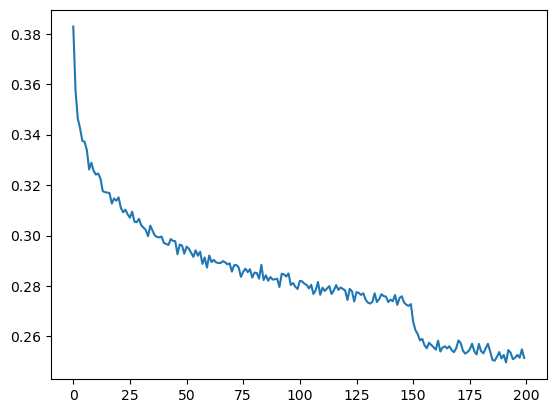

In [73]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [74]:
for layer in model.layers:
    layer.training = False

In [75]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits , y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7696945667266846
val 1.9658820629119873


In [76]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

nalai.
camerabelberto.
azran.
yechukwu.
zhithik.
janeliya.
teraegan.
nandrri.
dasandrian.
mystoe.
madducia.
deleyah.
analo.
avitore.
asa.
michai.
arlette.
rubet.
canden.
theodomey.
